# Detecting gender using images

In [10]:
%matplotlib inline

import json

import numpy as np
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Dropout, Dense, Flatten, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras import backend
from matplotlib import pyplot as plt
from keras.optimizers import Adam

from scipy import ndimage

In [11]:
def plots(ims, figsize=(12, 6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
    f = plt.figure(figsize=figsize)
    
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims) // rows, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [12]:
data_path = '/home/ubuntu/nbs/data/male_female_training_set_20170610_cleaned/'

In [13]:
FILES_PATH = 'https://files.fast.ai/models/'
CLASS_FILE='imagenet_class_index.json'
fpath = get_file(CLASS_FILE, FILES_PATH + CLASS_FILE, cache_subdir='models')

In [14]:
with open(fpath) as f:
    class_dict = json.load(f)

# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

## Standard VGG16

Define the basic pieces of the VGG architecture: one type of convolutional block and one type of fully connected "dense" block. Convolutional block definition:

Fully-connected definition:

Model creators subtracted the mean from each RGB value. Also, the values are provided as BGR for some reason...

In [20]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

In [21]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    # To do: try without drop out.
    model.add(Dropout(0.5))


def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224), output_shape=(3, 224, 224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    
    FCBlock(model)
    FCBlock(model)
    
    model.add(Dense(1000, activation='softmax'))
    
    return model

def finetune(model, batches):
    model.pop()
    for layer in model.layers:
        layer.trainable = False

    model.add(Dense(batches.nb_class, activation='softmax'))
    model.compile(
        optimizer=Adam(lr=0.001),
        loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [22]:
model = VGG_16()

* Convolutional blocks are for finding patterns in images.
* Dense (fully connected) blocks are for finding relationship betweens patterns.

In [23]:
gen = image.ImageDataGenerator()
batches = gen.flow_from_directory(
    data_path + 'train', target_size=(224, 224), class_mode='categorical', batch_size=4)
val_batches = gen.flow_from_directory(
    data_path + 'test', target_size=(224, 224), class_mode='categorical', batch_size=4)

Found 21799 images belonging to 3 classes.
Found 2640 images belonging to 3 classes.


In [25]:
fpath = get_file('vgg16.h5', FILES_PATH + 'vgg16.h5', cache_subdir='models')

In [26]:
model.load_weights(fpath)

In [20]:
model = finetune(model, batches)

In [14]:
model.fit_generator(
    batches, samples_per_epoch=batches.nb_sample,
    nb_epoch=3, validation_data=val_batches,
    nb_val_samples=val_batches.nb_sample)

Epoch 1/3
12216/24575 [=============>................] - ETA: 323s - loss: 1.6415 - acc: 0.7259

/home/ubuntu/anaconda2/lib/python2.7/site-packages/PIL/Image.py:869: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


24575/24575 [==============================] - 711s - loss: 1.8030 - acc: 0.7411 - val_loss: 1.0931 - val_acc: 0.8398
Epoch 2/3
24575/24575 [==============================] - 712s - loss: 2.2233 - acc: 0.7722 - val_loss: 1.5503 - val_acc: 0.8273
Epoch 3/3
24575/24575 [==============================] - 713s - loss: 2.3763 - acc: 0.7821 - val_loss: 1.5754 - val_acc: 0.8473


In [15]:
model.save_weights('gender_5_epochs.h5')

In [13]:
## Start from here to validate model
model.load_weights('gender_5_epochs.h5')

## Data augmentation experiments

On a small sample, trying a couple of different types of data augmenation.

Created a sample set like this:

```
for file in $(ls -p | grep -v / | tail -500)
do
mv $file ../../sample/train/female/
done
```

Technique credited to Jeremy Howard from Fast.ai, [Lesson 4: Practical Deep Learning for Coders (1h 5m 32s)](https://youtu.be/V2h3IOBDvrA?t=1h5m32s).

In [18]:
sample_data_path = data_path + 'sample/'

In [30]:
# Firstly, with no augmentation as baseline.
gen = image.ImageDataGenerator()
batches = gen.flow_from_directory(sample_data_path + 'train', target_size=(224, 224), class_mode='categorical', batch_size=64)
val_batches = gen.flow_from_directory(sample_data_path + 'test', target_size=(224, 224), class_mode='categorical', batch_size=64)

Found 2393 images belonging to 3 classes.
Found 400 images belonging to 3 classes.


In [15]:
def build_and_train(batches):
    model = VGG_16()
    model.load_weights(fpath)
    model = finetune(model, batches)
    model.fit_generator(
        batches, samples_per_epoch=batches.nb_sample,
        nb_epoch=3, validation_data=val_batches,
        nb_val_samples=val_batches.nb_sample)
    return model

In [14]:
def show_example_images(image_path, gen):
    img = np.expand_dims(ndimage.imread(image_path), 0)
    aug_iter = gen.flow(img)
    aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]
    plots(aug_imgs, (20,7), 2)

In [27]:
build_and_train(batches)

Epoch 1/3
2393/2393 [==============================] - 66s - loss: 1.3607 - acc: 0.6569 - val_loss: 0.8588 - val_acc: 0.7225
Epoch 2/3
2393/2393 [==============================] - 65s - loss: 0.9535 - acc: 0.7405 - val_loss: 0.8126 - val_acc: 0.7475
Epoch 3/3
2393/2393 [==============================] - 66s - loss: 0.8680 - acc: 0.7384 - val_loss: 0.7451 - val_acc: 0.7650


### Vertical shifts.

In [60]:
gen = image.ImageDataGenerator(height_shift_range=0.15)

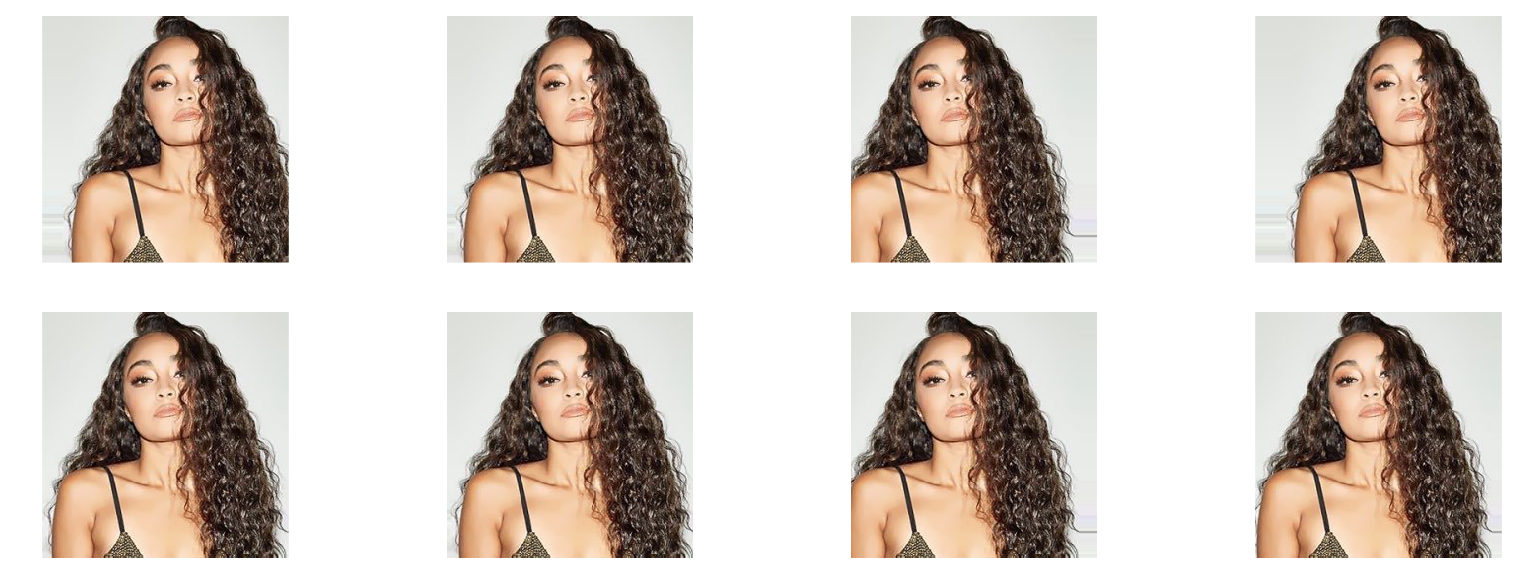

In [61]:
show_example_images(sample_data_path + '/train/female/twitter_withuhs.jpg', gen)

In [48]:
batches = gen.flow_from_directory(sample_data_path + 'train', target_size=(224, 224), class_mode='categorical', batch_size=64)

Found 2393 images belonging to 3 classes.


In [49]:
build_and_train(batches)

Epoch 1/3
2393/2393 [==============================] - 65s - loss: 1.4269 - acc: 0.6456 - val_loss: 0.7667 - val_acc: 0.7475
Epoch 2/3
2393/2393 [==============================] - 65s - loss: 1.0196 - acc: 0.7142 - val_loss: 0.7947 - val_acc: 0.7350
Epoch 3/3
2393/2393 [==============================] - 65s - loss: 0.9106 - acc: 0.7338 - val_loss: 0.6837 - val_acc: 0.7600


### Vertical flips

In [62]:
gen = image.ImageDataGenerator(vertical_flip=True)

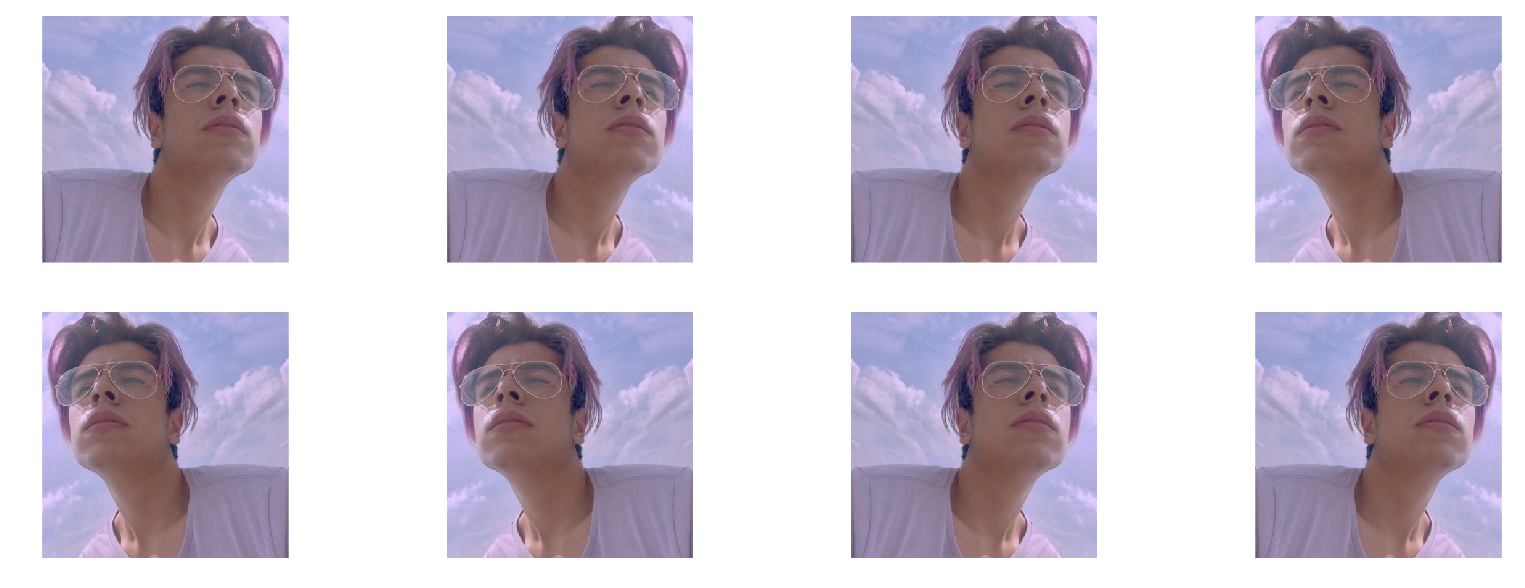

In [63]:
show_example_images(sample_data_path + '/train/male/twitter_thepugnificent.jpg', gen)

In [64]:
batches = gen.flow_from_directory(sample_data_path + 'train', target_size=(224, 224), class_mode='categorical', batch_size=64)
build_and_train(batches)

Epoch 1/3
2393/2393 [==============================] - 65s - loss: 1.3149 - acc: 0.6490 - val_loss: 0.7757 - val_acc: 0.7650
Epoch 2/3
2393/2393 [==============================] - 65s - loss: 1.0531 - acc: 0.7100 - val_loss: 0.8705 - val_acc: 0.7050
Epoch 3/3
2393/2393 [==============================] - 66s - loss: 0.8626 - acc: 0.7380 - val_loss: 0.7970 - val_acc: 0.7575


### "Shear" range

In [76]:
gen = image.ImageDataGenerator(shear_range=0.1)

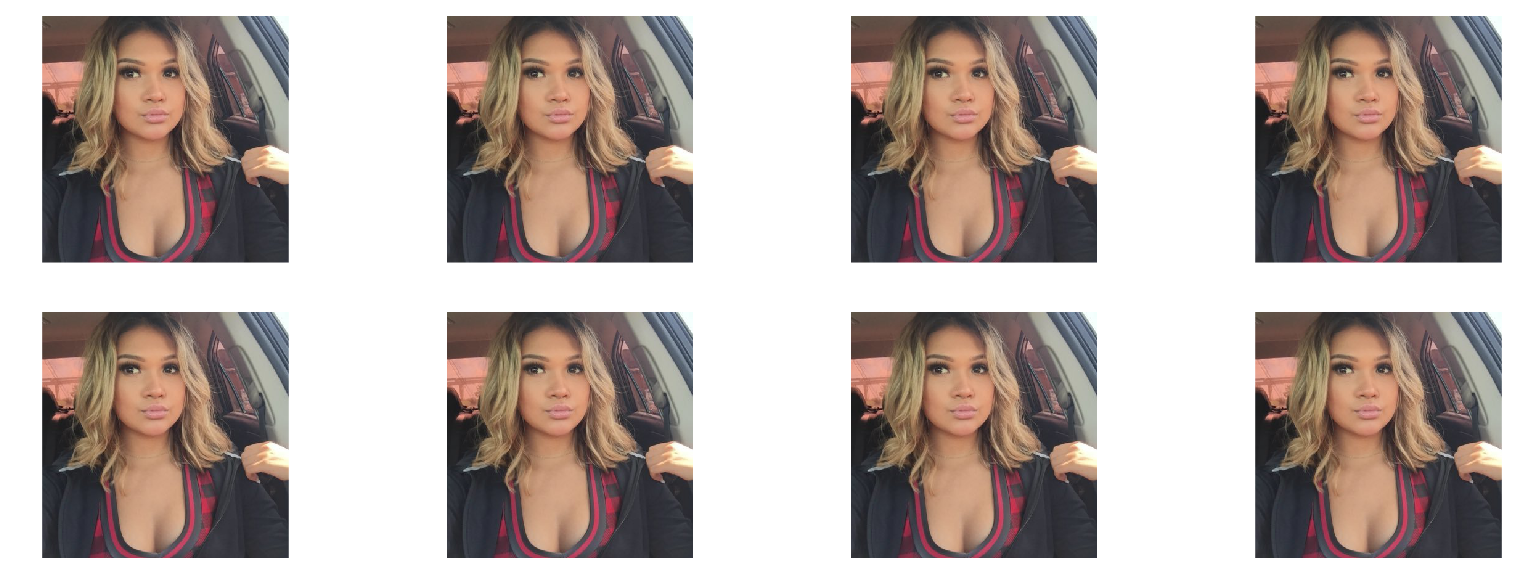

In [77]:
show_example_images(sample_data_path + '/train/female/twitter_sexaaylexy.jpg', gen)

In [78]:
batches = gen.flow_from_directory(sample_data_path + 'train', target_size=(224, 224), class_mode='categorical', batch_size=64)
build_and_train(batches)

Found 2393 images belonging to 3 classes.
Epoch 1/3
2393/2393 [==============================] - 66s - loss: 1.2886 - acc: 0.6690 - val_loss: 0.7831 - val_acc: 0.7525
Epoch 2/3
2393/2393 [==============================] - 65s - loss: 1.0111 - acc: 0.7254 - val_loss: 0.7490 - val_acc: 0.7525
Epoch 3/3
2393/2393 [==============================] - 66s - loss: 0.8570 - acc: 0.7430 - val_loss: 0.6945 - val_acc: 0.7525


### Zoom range

In [ ]:
# Also tried 0.4 and 0.3 and 0.2 seems to yield best results.
gen = image.ImageDataGenerator(zoom_range=0.2)

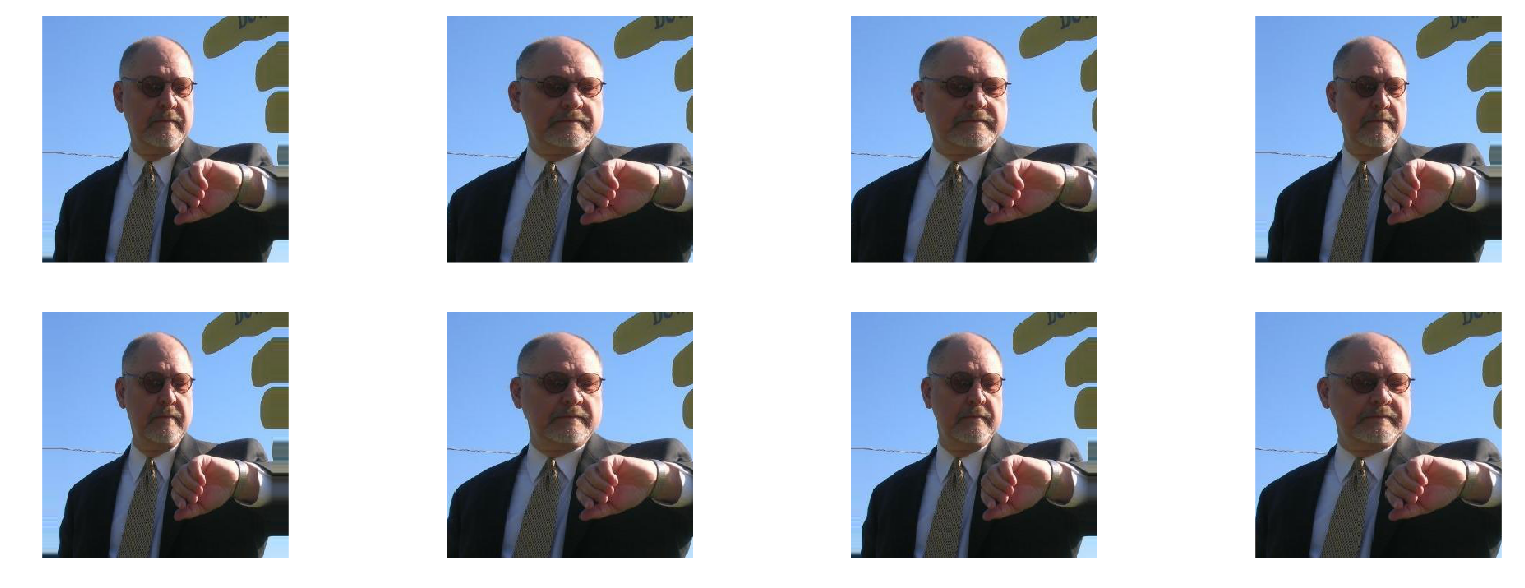

In [33]:
show_example_images(sample_data_path + '/train/male/twitter_thewordbureau.jpg', gen)

In [34]:
batches = gen.flow_from_directory(sample_data_path + 'train', target_size=(224, 224), class_mode='categorical', batch_size=64)
build_and_train(batches)

Found 2393 images belonging to 3 classes.
Epoch 1/3
2393/2393 [==============================] - 74s - loss: 1.2596 - acc: 0.6623 - val_loss: 0.8190 - val_acc: 0.7400
Epoch 2/3
2393/2393 [==============================] - 74s - loss: 1.0602 - acc: 0.7117 - val_loss: 0.7614 - val_acc: 0.7700
Epoch 3/3
2393/2393 [==============================] - 74s - loss: 0.9518 - acc: 0.7275 - val_loss: 0.8062 - val_acc: 0.7375


### Channel shift range

In [51]:
gen = image.ImageDataGenerator(channel_shift_range=4)

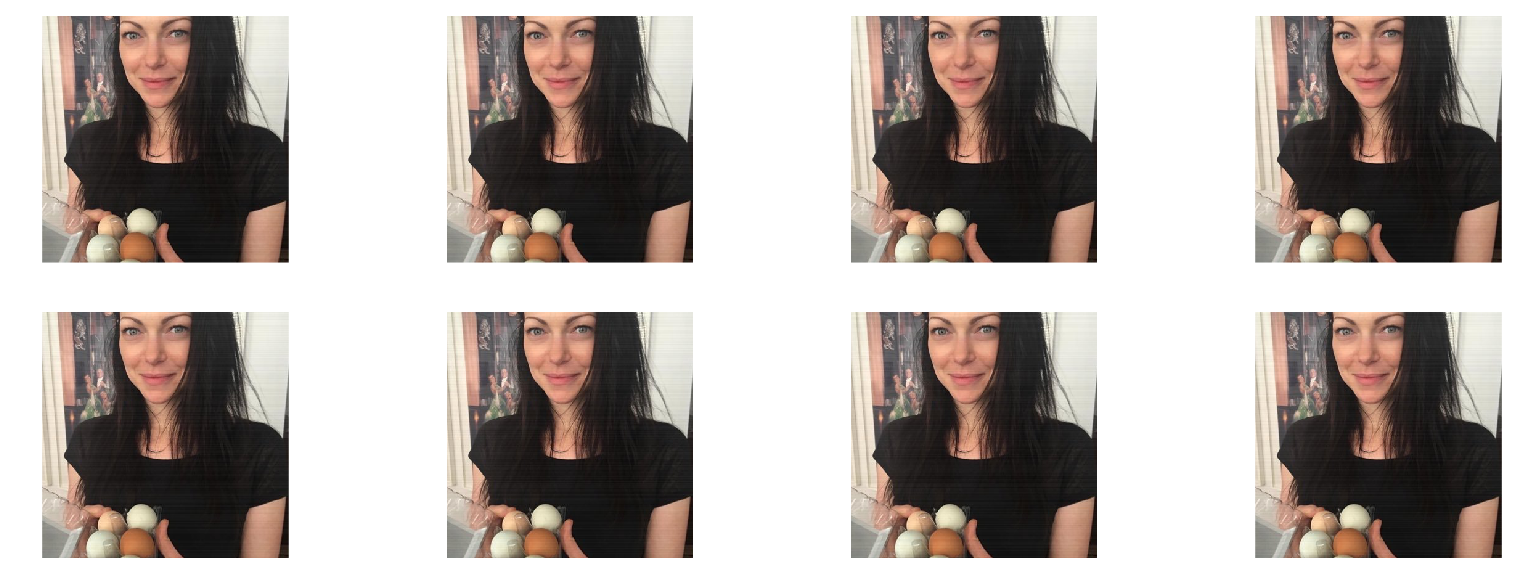

In [52]:
show_example_images(sample_data_path + 'train/female/twitter_tall_and_more.jpg', gen)

In [53]:
batches = gen.flow_from_directory(sample_data_path + 'train', target_size=(224, 224), class_mode='categorical', batch_size=64)
build_and_train(batches)

Found 2393 images belonging to 3 classes.
Epoch 1/3
2393/2393 [==============================] - 73s - loss: 1.2959 - acc: 0.6594 - val_loss: 0.7987 - val_acc: 0.7400
Epoch 2/3
2393/2393 [==============================] - 74s - loss: 0.9843 - acc: 0.7196 - val_loss: 0.7172 - val_acc: 0.7675
Epoch 3/3
2393/2393 [==============================] - 74s - loss: 0.8853 - acc: 0.7455 - val_loss: 0.7043 - val_acc: 0.7525


In [27]:
gen = image.ImageDataGenerator(
    height_shift_range=0.15, vertical_flip=True, shear_range=0.1, zoom_range=0.2, channel_shift_range=4)
batches = gen.flow_from_directory(
    data_path + 'train', target_size=(224, 224), class_mode='categorical', batch_size=4)

val_batches = image.ImageDataGenerator().flow_from_directory(
    data_path + 'test', target_size=(224, 224), class_mode='categorical', batch_size=4)

Found 21799 images belonging to 3 classes.
Found 2640 images belonging to 3 classes.


In [ ]:
model = VGG_16()
model.load_weights(fpath)
model = finetune(model, batches)
model.fit_generator(
    batches, samples_per_epoch=batches.nb_sample,
    nb_epoch=3, validation_data=val_batches,
    nb_val_samples=val_batches.nb_sample)

Epoch 1/3
 2832/21799 [==>...........................] - ETA: 511s - loss: 1.4619 - acc: 0.6949